#주제: 다음 분기에 어떤 게임을 출시해야하는가
1980년부터 현재까지 출시된 게임 데이터를 분석하여 다음분기에 어떤 게임을 출시해야 하는지를 알아보겠습니다.    
목표는 높은 출고량(판매량)을 기록할 수 있는 게임을 출시하는 것입니다.

판단해야할 항목은 아래와 같습니다:
1. 장르
2. 지역
3. 플랫폼

#준비: 데이터 전처리
EDA를 통해 수집된 데이터를 확인하였을 때, 아래 전처리과정이 필요하였습니다:
1. 결측치 제거
2. 연도 형식 4자리로 통일
3. 출고량 형식 float로 통일
4. 총 출고량(Total_Sales) 컬럼 추가 (feature-engineering)

In [76]:
import pandas as pd

df = pd.read_csv('/content/vgames2.csv', index_col=0)
original_shape = df.shape
df = df.dropna() # 1. 결측치 행 제거
df['Year'] = df['Year'].astype('int32')

def to_4_digits(year):
  """2자리 문자열로 된 연도를 4자리로 변환"""
  if len(str(year)) == 4:
    return year
  else:
    if year > 22:
      return year + 1900
    else:
      return year + 2000

df['Year'] = df['Year'].apply(to_4_digits) # 2. 연도 형식 4자리로 통일

def to_float(m):
  """K와 M이 섞인 숫자를 M기준 소수점으로 변환"""
  if 'K' in m:
    return float(m[:-1]) / 1000
  if 'M' in m:
    return float(m[:-1])
  else:
    return float(m)

for col in ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']:
  df[col] = df[col].apply(to_float) # 3. 출고량 형식 float로 통일

df['Total_Sales'] = df.NA_Sales+df.EU_Sales+df.JP_Sales+df.Other_Sales # 4. 총 출고량(Total_Sales) 컬럼 추가
print('결측으로 인해 제거된 행:', original_shape[0]-df.shape[0], "건")
df

결측으로 인해 제거된 행: 357 건


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
1,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
2,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
4,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
16594,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16595,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16596,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16597,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38




---


#질문1: 지역에 따른 장르 선호도가 있을까
출시된 게임들의 지역별 출고량 데이터가 있으므로 아래과정을 통해 장르vs지역에 대한 contingency table을 만들어 독립성을 검정할 수 있습니다.
1. 장르별 지역 출고량 합 구하기
2. 해당 데이터의 카이제곱 검정
3. 지역별 최고 판매량을 가진 장르 시각화

In [37]:
# 1. 장르별 지역 출고량 합 구하기
obs = df.groupby('Genre').sum()
obs = obs[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
obs

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Genre,,,,
Action,858.75,513.64,156.60,183.99
Adventure,101.79,63.66,51.87,16.70
Fighting,220.35,99.90,87.14,36.15
Misc,394.73,208.15,104.18,72.64
Platform,445.38,200.63,130.53,51.45
Puzzle,121.58,50.47,56.24,12.44
Racing,354.70,235.02,56.32,76.51
Role-Playing,318.76,183.09,342.93,56.73
Shooter,574.48,310.23,38.18,101.86


In [38]:
# 2. 해당 데이터의 카이제곱 검정
from scipy.stats import chi2_contingency

chi2_p = chi2_contingency(obs)[1]
print("chi2 p-value: ", chi2_p)
print("--------해석---------")
print('''카이제곱 p-value가 0.05 미만이므로 귀무가설을 기각한다
-> 장르와 지역은 서로 독립이 아니다(연관성이 있다)''')

chi2 p-value:  9.635373883711956e-123
--------해석---------
카이제곱 p-value가 0.05 미만이므로 귀무가설을 기각한다
-> 장르와 지역은 서로 독립이 아니다(연관성이 있다)


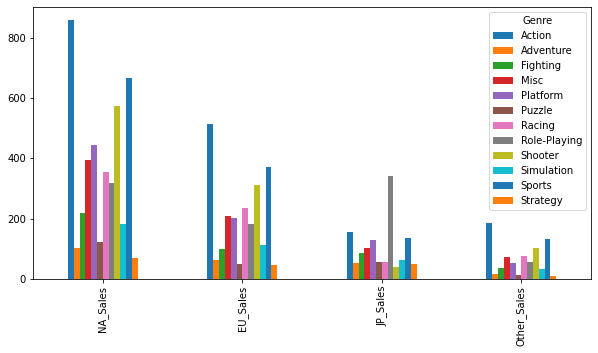

In [39]:
# 3. 지역별 최고 판매량을 가진 장르 시각화
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

obs.T.plot.bar()
plt.show()

###결론
지역별 선호 장르는 유의미하게 존재하며 아래와 같습니다(2순위까지 표기):  

지역  | 1순위 | 2순위
---|---|---
NA|Action|Sports
EU|Action|Sports
JP|Role-Playing|Action
Other|Action|Sports



---
#질문2: 연도별 게임의 트렌드가 있을까
트렌드의 정의가 다소 모호할 수 있습니다. 여기서는 해당 연도에 가장 많이 *출시*된 장르를 기준으로 파악해보겠습니다. *출고(판매)*가 아닌 *출시*인 이유는 트렌드가 아닌데 성공하여 큰 출고를 기록하는 경우도 있기 때문입니다. 따라서 해당연도의 트렌드는 가장 많이팔린 것이 아닌, 애초에 얼마나 많은 게임이 출시되었는지를 보는 것으로 규정하였습니다.   
파악 방법은 마찬가지로 연도/장르별 출시된 게임의 개수(빈도)를 cross-tab하여 카이제곱을 통해 독립성을 검정하도록 하겠습니다.
1. 연도에 따른 장르별 게임 출시 수
2. 해당 데이터의 카이제곱
3. 시각화

In [49]:
# 1. 연도에 따른 장르별 게임 출시 수
obs2 = df.groupby(['Year', 'Genre']).count()['Name']
obs2 = obs2.reset_index()
obs2 = obs2.pivot('Year', 'Genre', 'Name')
obs2 = obs2.fillna(0)
obs2

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year,,,,,,,,,,,,
1980,1.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1981,25.0,0.0,0.0,0.0,3.0,2.0,1.0,0.0,10.0,1.0,4.0,0.0
1982,18.0,0.0,0.0,1.0,5.0,3.0,2.0,0.0,5.0,0.0,2.0,0.0
1983,7.0,1.0,0.0,1.0,5.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1984,1.0,0.0,0.0,1.0,1.0,3.0,3.0,0.0,3.0,0.0,2.0,0.0
1985,2.0,0.0,1.0,0.0,4.0,4.0,0.0,0.0,1.0,1.0,1.0,0.0
1986,6.0,0.0,0.0,0.0,6.0,0.0,1.0,1.0,4.0,0.0,3.0,0.0
1987,2.0,1.0,2.0,0.0,2.0,0.0,0.0,3.0,2.0,0.0,4.0,0.0
1988,2.0,0.0,0.0,0.0,4.0,1.0,1.0,3.0,1.0,1.0,2.0,0.0


In [50]:
# 2. 해당 데이터의 카이제곱 검정
from scipy.stats import chi2_contingency

chi2_p = chi2_contingency(obs2)[1]
print("chi2 p-value: ", chi2_p)
print("--------해석---------")
print('''카이제곱 p-value가 0.05 미만이므로 귀무가설을 기각한다
-> 연도와 장르는 독립이 아니다(연관성이 있다)''')

chi2 p-value:  0.0
--------해석---------
카이제곱 p-value가 0.05 미만이므로 귀무가설을 기각한다
-> 연도와 장르는 독립이 아니다(연관성이 있다)


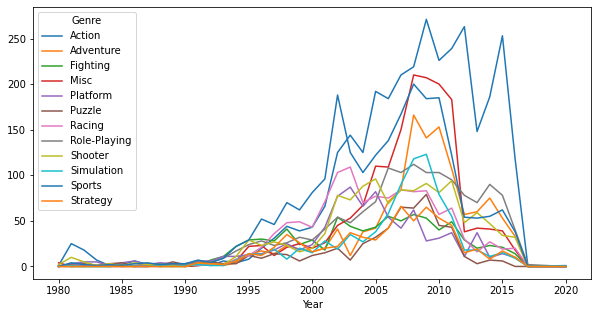

In [51]:
# 3. 시각화
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

obs2.plot.line()
plt.show()

###결론
연도별 트렌드는 존재하며 연도별 최다 출시 장르는 아래와 같다

In [53]:
obs2.idxmax(axis=1)

Year
1980            Misc
1981          Action
1982          Action
1983          Action
1984          Puzzle
1985        Platform
1986          Action
1987          Sports
1988        Platform
1989          Puzzle
1990          Action
1991          Sports
1992        Fighting
1993        Fighting
1994        Fighting
1995        Fighting
1996          Sports
1997          Sports
1998          Sports
1999          Sports
2000          Sports
2001          Sports
2002          Sports
2003          Action
2004          Action
2005          Action
2006          Action
2007          Action
2008          Action
2009          Action
2010          Action
2011          Action
2012          Action
2013          Action
2014          Action
2015          Action
2016          Action
2017    Role-Playing
2020      Simulation
dtype: object



---


#최근 10년간 출고량이 높은 게임 분석 및 시각화
연도별 트렌드가 의미있다는 것을 위에서 확인했기에, 과거 자료를 배제하고 최근 10년간을 기준으로 출고량이 높은 100개의 게임을 추출하여 분석 및 시각화합니다.
1. TOP100의 총 출고량 그래프
2. TOP100의 지역별 출고량 합
3. TOP100의 장르별 출고량 합
4. TOP100의 플랫폼 분포

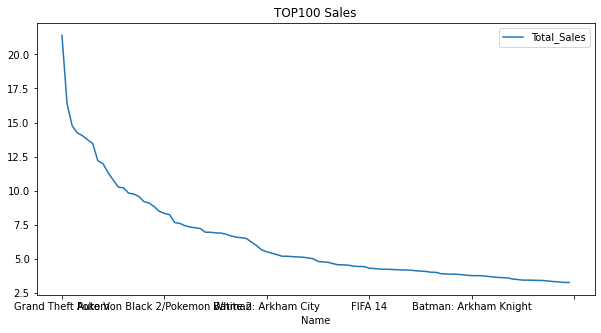

In [115]:
# 1. 총 출고량 그래프
top_df = df.sort_values('Total_Sales', ascending=False)
top_df = top_df[top_df['Year'] > 2010]
top_df = top_df[:100]
top_df.plot.line(x='Name', y='Total_Sales', title='TOP100 Sales')
plt.show()

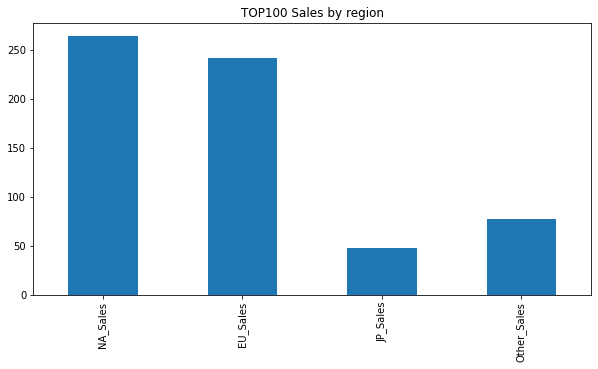

In [116]:
# 2. TOP100의 지역별 출고량 합
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

sales_df = top_df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()
sales_df.plot.bar(title="TOP100 Sales by region")
plt.show()

###결론 1
가장 많이 팔린 100개의 게임이 가장 많은 판매를 기록한 지역은 NA > EU > 외 나머지 순입니다.

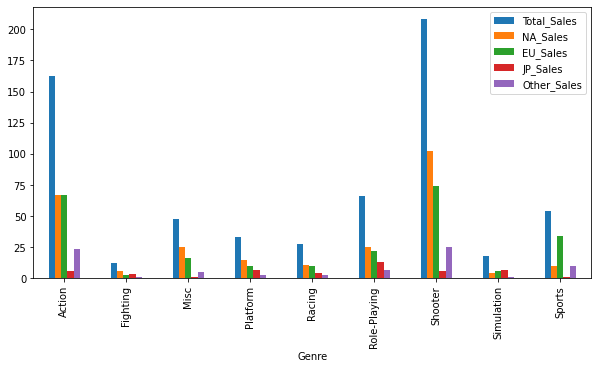

In [117]:
# 3. TOP100의 장르별 출고량 합
genre_df = top_df.groupby('Genre').sum()[['Total_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
genre_df.plot.bar()
plt.show()

###결론 2
가장 많이 팔린 100개의 게임 중 가장 많이 팔린 장르는 Shooter > Platform > 그 외 순입니다.

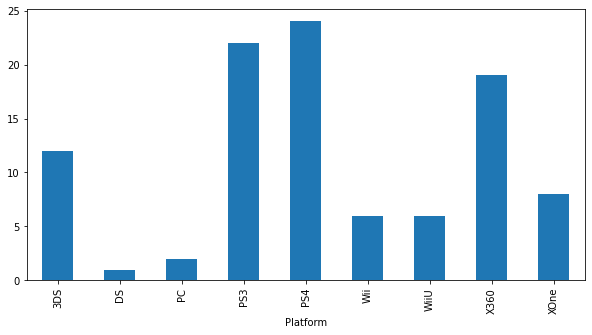

In [118]:
# 4. TOP100의 플랫폼 분포
plat_df = top_df.groupby('Platform').count()['Name']
plat_df.plot.bar()
plt.show()

###결론 3
가장 많이 팔린 100개의 게임이 출시된 플랫폼은 PS4 > PS3 > 그외 순입니다.

#최종 결론
지역에 따른 선호도는 유의미하며, 연도별 트렌드도 존재하는 것을 확인했습니다.   
이때 최근 10년간 출고량이 가장 높았던(=성공적이었던) 게임들을 보았을 때 다음과 같은 특징이 있습니다.

1. NA와 EU에서 모두 높은 판매량 기록
2. Shooter 혹은 Action 장르
3. PS4

따라서 다음 분기에 출시해야할 게임은 NA와 EU에서 높은 선호도를 보이는 Action 혹은 Shooter 장르로 PS4 플랫폼에 출시해야합니다.